In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
## To download vader files
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import spearmanr, pearsonr

<h3> Raw Data </h3>

In [7]:
druglib_raw = pd.read_csv('./dataset/druglib/druglib.csv')
druglib_raw.shape

(4214, 8)

In [11]:
druglib = pd.read_csv('./dataset/druglib/druglib_processed.csv')
druglib.shape

(4212, 9)

In [20]:
druglib.head()

,URL,Drug,Condition,Age,Sex,Rating,Reviews,Side Effect,Age_Group
0,http://www.druglib.com/ratingsreviews/abilify/,abilify,bipolar disorder,26,Female,3,I was prescribed Abilify (15mg/daily) to assi...,A very uncomfortable inner restlessness was t...,25-34
1,http://www.druglib.com/ratingsreviews/abilify/,abilify,bipolar disorder,29,Female,8,the abilify decreased the need for daily klon...,"I became drowsy, however, with adequate sleep...",25-34
2,http://www.druglib.com/ratingsreviews/abilify/,abilify,anxiety and depression,43,Female,10,I take one pill of each 1st thing in the am.....,no side effects have been noticed,35-44
3,http://www.druglib.com/ratingsreviews/abilify/,abilify,depression,50,Female,2,I am only taking ativan & getting psychologic...,but it caused memory loss and again an incid...,45-54
4,http://www.druglib.com/ratingsreviews/abilify/,abilify,bipolar disorder,50,Male,2,Not much to tell. I was just starting treatm...,Headache first morning at 4AM that was reliev...,45-54


<h1> Exploratory Data Analysis </h1> 

In [15]:
len(druglib.Drug.unique())

560

In [19]:
len(druglib.Condition.str.lower().unique())

1711

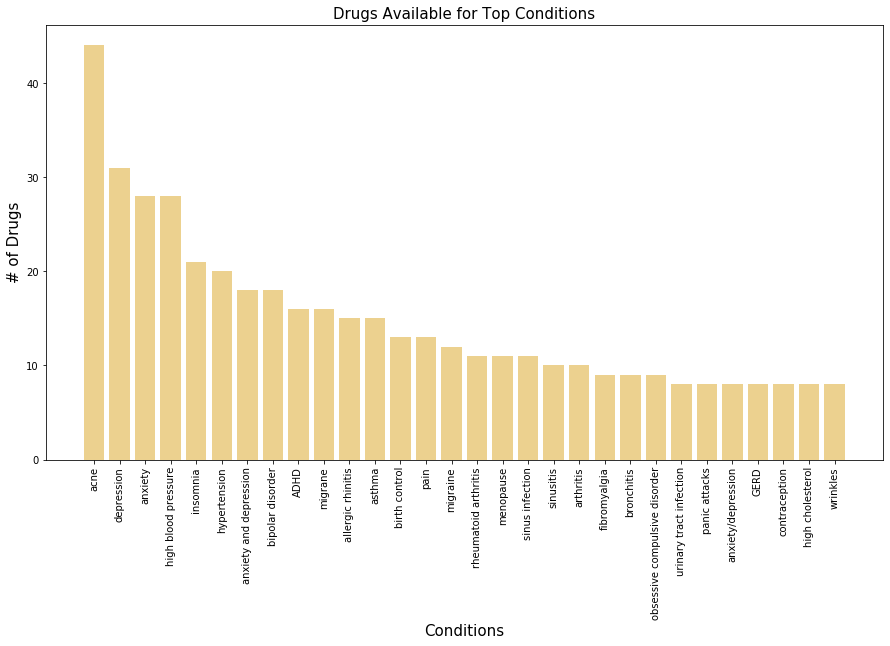

In [21]:
# Number of drugs available for top conditions
df = druglib.groupby(['Condition'])['Drug'].nunique().sort_values(ascending = False).reset_index().head(30)
plt.rcParams['figure.figsize'] = [15, 8]
plt.bar(x=df['Condition'],height = df['Drug'],color = 'goldenrod',alpha=0.5)
plt.xticks(rotation=90)
plt.title('Drugs Available for Top Conditions', fontsize = 15)
plt.xlabel('Conditions', fontsize = 15)
plt.ylabel('# of Drugs', fontsize = 15)
plt.show()

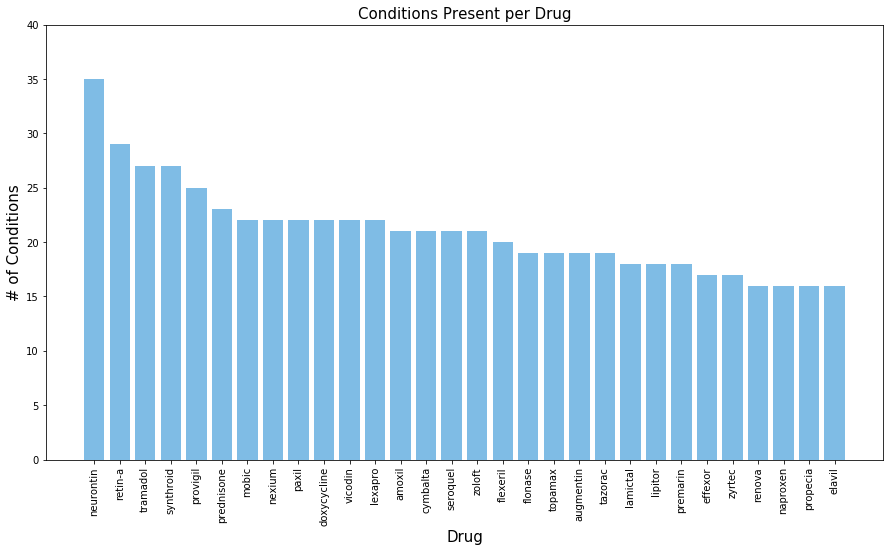

In [24]:
# Number of conditions present per drug
df = druglib.groupby(['Drug'])['Condition'].nunique().sort_values(ascending = False).reset_index().head(30)
plt.rcParams['figure.figsize'] = [15, 8]
plt.bar(x=df['Drug'],height = df['Condition'],color = '#007acc',alpha=0.5)

plt.title('Conditions Present per Drug', fontsize = 15)
plt.xlabel('Drug', fontsize = 15)
plt.ylabel('# of Conditions', fontsize = 15)
plt.xticks(rotation=90)
plt.yticks(np.arange(0,45,5))
plt.show()

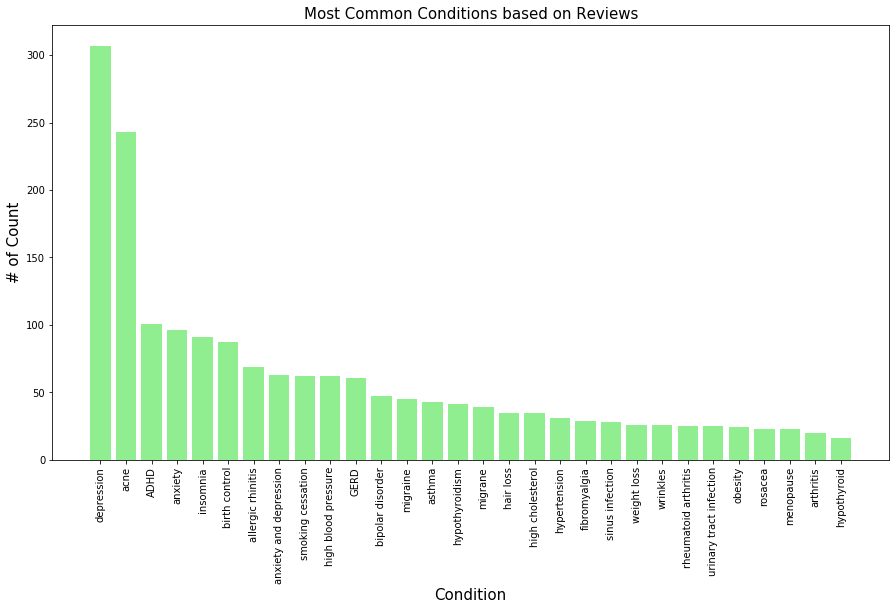

In [72]:
# Most Common Conditions based on Reviews
df = druglib['Condition'].value_counts().head(30).reset_index()
df.columns = ['Condition','Count']
plt.rcParams['figure.figsize'] = [15, 8]
plt.bar(x=df['Condition'],height = df['Count'],color = 'lightgreen')
plt.xticks(rotation=90)
plt.title('Most Common Conditions based on Reviews', fontsize = 15)
plt.xlabel('Condition', fontsize = 15)
plt.ylabel('# of Count', fontsize = 15)
plt.show()

<h3> Rating Distribution </h3>

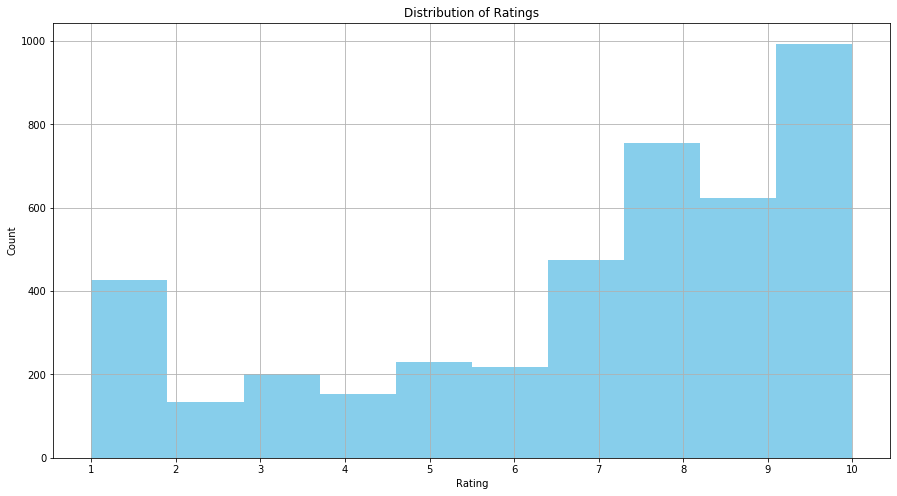

In [78]:
# Look at distribution of ratings
druglib.Rating.hist(color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 11)]);

Text(0, 0.5, 'Count')

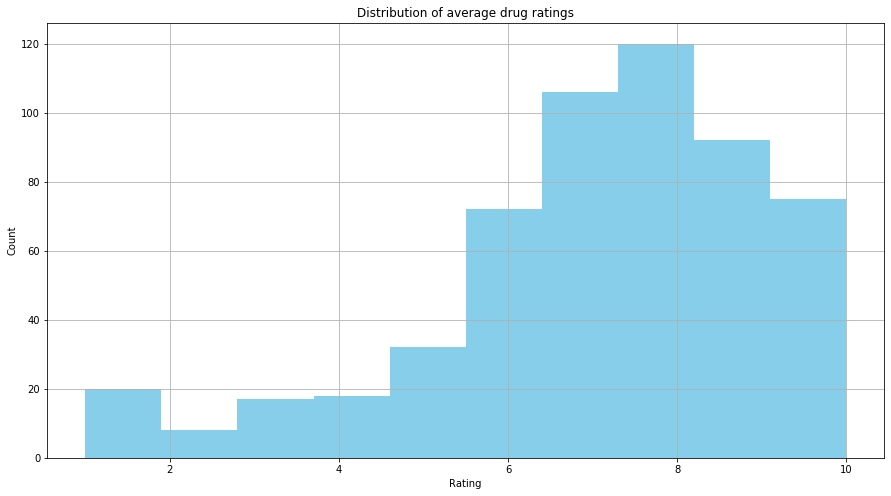

In [79]:
rating_avgs = (druglib['Rating'].groupby(druglib['Drug']).mean())
rating_avgs.hist(color='skyblue')
plt.title('Distribution of average drug ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

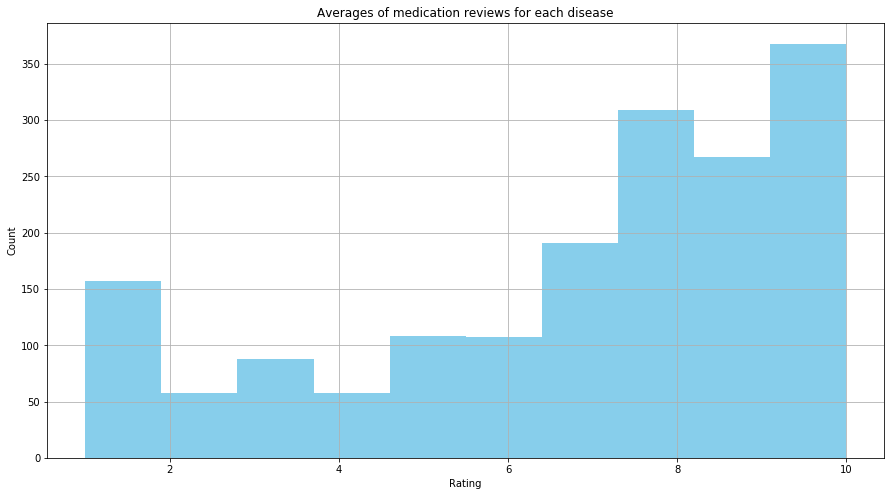

In [81]:
rating_avgs = (druglib['Rating'].groupby(druglib['Condition']).mean())
rating_avgs.hist(color='skyblue')
plt.title('Averages of medication reviews for each disease')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

<h1>Sentiment Analysis</h1>

<h3> Sentiment analysis on user reviews. </h3>


In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

<h3> Filtering missing reviews</h3>

In [59]:
print("Before removing missing reviews: ", druglib.shape)
druglib_df = druglib[druglib['Reviews'] != " "].reset_index()
print("After removing missing reviews: ", druglib_df.shape)

Before removing missing reviews:  (4212, 10)
After removing missing reviews:  (4210, 11)


In [60]:
druglib_df['sentiment'] = druglib_df['Reviews'].apply(lambda x: sid.polarity_scores(x)['compound'])

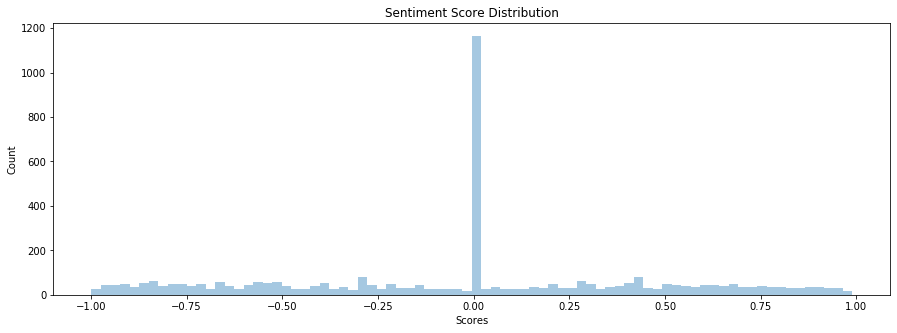

In [61]:
plt.figure(figsize=(15,5))
ax = sns.distplot(druglib_df['sentiment'],bins=80,kde=False)
plt.title('Sentiment Score Distribution')
plt.xlabel('Scores')
plt.ylabel('Count');

<h1> Statistical Analysis </h1>

<h3> Univariate Analysis (Ex: Pie chart) 
    - Distribution of review ratings </h3>

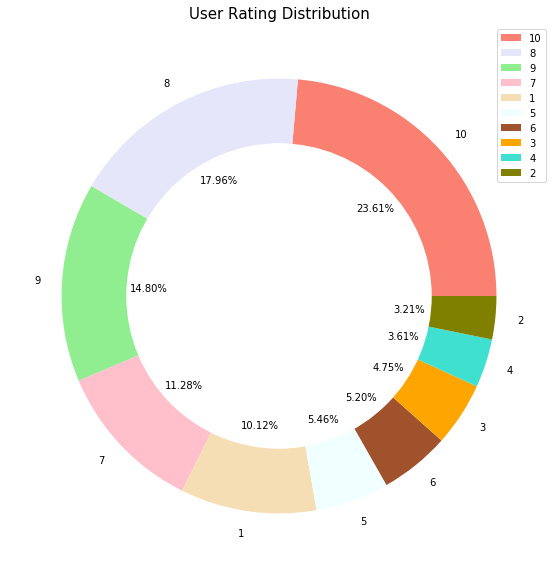

In [62]:
# Frequency of each rating
df = druglib_df['Rating'].value_counts().reset_index()

# Converting float rating values to int
df.columns = ['Rating','count']
df = df.astype({'Rating':'int'})

# Plotting user rating distribution
size = df['count']
colors = ['salmon','lavender','lightgreen','pink','wheat','azure','sienna','orange','turquoise','olive']
labels = df['Rating']

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size,colors = colors,labels = labels, autopct = '%.2f%%')
plt.title('User Rating Distribution', fontsize = 15)
plt.legend()
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.show()

<h3> Bivariate analysis (Ex: scatter plot, joint plots) is used to show relationship between two variables.</h3>
<h3> 1. Joint plot of Sentiment Score vs Rating </h3>

Joint plot of Sentiment Score vs Rating


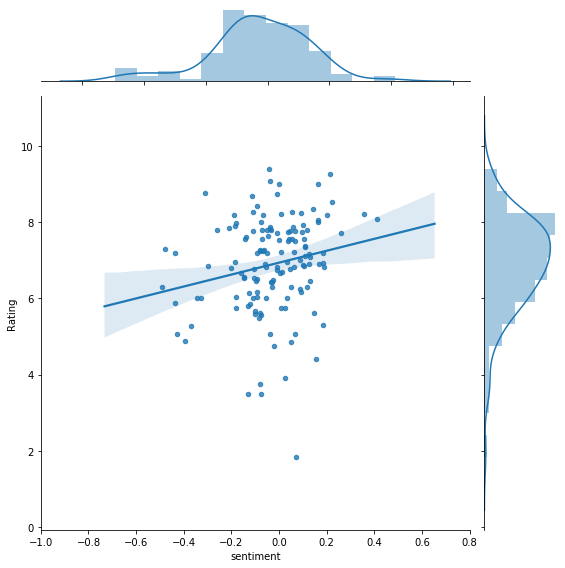

In [65]:
# Joint plot of sentiment score vs rating

reviews_per_drug = druglib_df.groupby(['Drug']).agg({
    'index': pd.Series.nunique
}).reset_index()

drugs_sentiment = druglib_df.groupby(['Drug'])

drugs_sentiment = drugs_sentiment.agg({
    'sentiment': np.mean, 
    'Rating': np.mean,
    'index': pd.Series.nunique
}).reset_index()

drugs_sentiment = drugs_sentiment[drugs_sentiment['index'] > reviews_per_drug.quantile(q=0.75)[0]]

sns.jointplot(x= 'sentiment', y= 'Rating', data=drugs_sentiment, kind='reg', height=8, scatter_kws={'s': 20})
print('Joint plot of Sentiment Score vs Rating')
plt.xticks(np.arange(-1,1,0.2))
plt.show()

<h3> Correlation Coefficients (Between Sentiment Score and Rating) </h3>

In [69]:
# Spearman correlation between sentiment and rating
spearmanr(drugs_sentiment['sentiment'], drugs_sentiment['Rating'])

SpearmanrResult(correlation=0.21439016913470077, pvalue=0.011266016845272947)

In [70]:
# Pearson correlation between sentiment and rating
pearsonr(drugs_sentiment['sentiment'], drugs_sentiment['Rating'])

(0.1993790670766161, 0.018617922716302176)